# 머신러닝을 이용한 가뭄예측

## 한글데이터 처리를 위한 사전작업

In [1]:
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

**(Runtime 재시작 필요)**

In [2]:
# import matplotlib.pyplot as plt
# import matplotlib as mpl 
# %matplotlib inline

# plt.rcParams['axes.unicode_minus'] = False

# path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# font_name = mpl.font_manager.FontProperties(fname=path).get_name()
# mpl.rc('font', family=font_name)
# mpl.font_manager._rebuild()

In [3]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc 

get_ipython().run_line_magic("matplotlib", "inline")

path = "C:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    rc("font", family="Arial Unicode MS")
elif platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name() 
    rc("font", family=font_name)
else:
    print("Unkown system. sorry~~")

plt.rc('axes', unicode_minus=False)

## 데이터 수집
- 기상자료개방포털(https://data.kma.go.kr)에서 다운로드 
- Feature: 종관기상관측(ASOS)
- Label: 표준강수지수

## 데이터 가공

### 파일 읽기

In [4]:
import os

files = os.listdir('../data')
asos_csv_files = [file for file in files if file.startswith("OBS_ASOS_")]
asos_csv_files[:2]

['OBS_ASOS_DD_19900701_19901231.csv', 'OBS_ASOS_DD_19910101_20001231.csv']

In [5]:
import pandas as pd

tmp = []
for csv_file in asos_csv_files:
  tmp.append(pd.read_csv('../data/' + csv_file, encoding='euc-kr'))

asos_raw = pd.concat(tmp)
asos_raw.head(2)

,지점,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),평균 풍속(m/s),평균 이슬점온도(°C),평균 상대습도(%),평균 현지기압(hPa)
0,90,속초,1990-07-01,16.5,14.9,19.5,0.3,2.2,15.2,92.0,1012.8
1,90,속초,1990-07-02,16.2,14.9,17.2,21.3,3.2,15.6,95.5,1008.8


In [6]:
asos = asos_raw[['지점', '일시'
                , '평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '평균 현지기압(hPa)'
                , '일강수량(mm)', '평균 풍속(m/s)', '평균 이슬점온도(°C)', '평균 상대습도(%)']].copy()
asos.rename(columns = {
    '평균기온(°C)' : '평균기온',
    '최저기온(°C)' : '최저기온',
    '최고기온(°C)' : '최고기온',
    '평균 현지기압(hPa)' : '기압',
    '일강수량(mm)' : '강수량',
    '평균 풍속(m/s)' : '풍속',
    '평균 이슬점온도(°C)' : '이슬점',
    '평균 상대습도(%)' : '상대습도'
    }, inplace = True)
asos.sort_values('일시' ,inplace=True)
asos.reset_index(drop=True, inplace=True)
asos.head(2)

,지점,일시,평균기온,최저기온,최고기온,기압,강수량,풍속,이슬점,상대습도
0,90,1990-07-01,16.5,14.9,19.5,1012.8,0.3,2.2,15.2,92.0
1,277,1990-07-01,18.3,16.5,20.4,1005.4,NaN,4.0,13.9,76.0


In [7]:
asos.tail(2)

,지점,일시,평균기온,최저기온,최고기온,기압,강수량,풍속,이슬점,상대습도
279789,212,2022-05-31,18.8,11.4,27.4,991.6,NaN,1.5,6.6,50.5
279790,281,2022-05-31,23.0,16.9,30.4,996.9,NaN,2.2,7.3,41.1


In [8]:
asos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279791 entries, 0 to 279790
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   지점      279791 non-null  int64  
 1   일시      279791 non-null  object 
 2   평균기온    279734 non-null  float64
 3   최저기온    279784 non-null  float64
 4   최고기온    279783 non-null  float64
 5   기압      279727 non-null  float64
 6   강수량     100734 non-null  float64
 7   풍속      279728 non-null  float64
 8   이슬점     279692 non-null  float64
 9   상대습도    279676 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 21.3+ MB


#### 결측치를 확인 및 수정
- 결측치를 확인하기 위해 isna() 함수를 이용.
- 강수량의 경우, 비가 내리지 않는날에 대하여 값이 들어오지 않음을 확인 -> 0으로 변경
- 나머지 결측치의 경우, 날씨의 연속성을 고려하여 전일자 데이터로 채움.

In [9]:
asos.isna().sum()

지점           0
일시           0
평균기온        57
최저기온         7
최고기온         8
기압          64
강수량     179057
풍속          63
이슬점         99
상대습도       115
dtype: int64

In [10]:
asos['강수량'] = asos['강수량'].fillna(0)
asos = asos.fillna(method='ffill')
asos.isna().sum()

지점      0
일시      0
평균기온    0
최저기온    0
최고기온    0
기압      0
강수량     0
풍속      0
이슬점     0
상대습도    0
dtype: int64

#### ASOS 관측데이터의 6개월 평균값 계산
- Label인 SPI6는 6개월 표준강수지수 이기때문에 두 Feature 값을 모두 6개월 평균 가공

In [11]:
asos['연도'] = asos['일시'].map(lambda x: x.split('-')[0])
asos['월'] = asos['일시'].map(lambda x: x.split('-')[1])
asos.head(2)

,지점,일시,평균기온,최저기온,최고기온,기압,강수량,풍속,이슬점,상대습도,연도,월
0,90,1990-07-01,16.5,14.9,19.5,1012.8,0.3,2.2,15.2,92.0,1990,07
1,277,1990-07-01,18.3,16.5,20.4,1005.4,0.0,4.0,13.9,76.0,1990,07


In [12]:
asos_mean = asos.groupby(by=['지점', '연도', '월']).mean()
asos_mean.head(2)

평균기온       최저기온       최고기온           기압       강수량        풍속  \
지점 연도   월                                                                      
90 1990 07  21.425806  19.451613  24.387097  1005.903226  8.477419  2.390323   
        08  24.683871  21.616129  28.274194  1006.703226  3.564516  2.209677   

                  이슬점       상대습도  
지점 연도   월                         
90 1990 07  19.938710  91.925806  
        08  21.967742  85.945161

#### 지점별로 6개월씩 rolling 함수를 이용하여 평균값을 연산

In [13]:
asos_pos_list = list(set(asos_mean.index.map(lambda x: x[0])))

tmp = []
for pos in asos_pos_list:
    tmp.append(pd.concat([asos_mean.loc[pos].rolling(window=6).mean().dropna()], keys=[pos], names=['지점']))

asos_mean_6m = pd.concat(tmp)
asos_mean_6m.head()

평균기온       최저기온       최고기온           기압       강수량        풍속  \
지점  연도   월                                                                      
129 1990 12  16.115466  11.923459  21.463136  1013.037455  5.297903  1.957455   
    1991 01  11.696649   7.230448  17.316900  1016.229391  4.033387  1.790789   
         02   7.288411   2.807675  12.876231  1018.844963  2.998671  1.889272   
         03   4.551171  -0.032002  10.230031  1020.095375  1.590678  1.974128   
         04   4.074756  -0.592898   9.807862  1019.495662  1.922901  2.086404   

                   이슬점       상대습도  
지점  연도   월                         
129 1990 12  12.064068  78.620968  
    1991 01   7.369982  76.798387  
         02   2.783077  75.348368  
         03  -0.212855  73.766594  
         04  -0.940256  72.506540

### 테스트 데이터 준비하기
- 테스트 데이터의 구성은 이전 5개월의 월 평균값의 합 + 최근 20년간 해당 월 평균값을 6으로 나눈 수치

In [14]:
asos_mean.head(2)

평균기온       최저기온       최고기온           기압       강수량        풍속  \
지점 연도   월                                                                      
90 1990 07  21.425806  19.451613  24.387097  1005.903226  8.477419  2.390323   
        08  24.683871  21.616129  28.274194  1006.703226  3.564516  2.209677   

                  이슬점       상대습도  
지점 연도   월                         
90 1990 07  19.938710  91.925806  
        08  21.967742  85.945161

#### 이전 5개월 월 평균의 합

In [15]:
import numpy as np

tmp = []

for pos in asos_pos_list:
    df = asos_mean.loc[pos].rolling(window=5).sum().dropna()
    df.loc[('2022', '06'),:] = np.nan
    tmp.append(pd.concat([df], keys=[pos], names=['지점']).shift(1))

asos_mean_5m = pd.concat(tmp)
asos_mean_5m.tail()
asos_mean_priv_5m = asos_mean_5m.dropna()
asos_mean_priv_5m.head()

평균기온       최저기온        최고기온           기압        강수량  \
지점  연도   월                                                              
129 1990 12  94.889570  73.440753  122.572366  5056.973118  30.242258   
    1991 01  71.863763  49.360108  100.382043  5074.708602  23.577742   
         02  44.641183  22.024624   72.978817  5092.537634  16.377742   
         03  23.003802   0.066052   51.164055  5101.846444   7.305361   
         04  13.161866  -8.330722   39.770507  5102.920637   9.544071   

                    풍속        이슬점        상대습도  
지점  연도   월                                     
129 1990 12   9.480215  74.819892  396.548387  
    1991 01   9.009247  50.648925  388.000000  
         02   9.196344  22.419892  379.758065  
         03   9.418963  -0.244869  371.780207  
         04  10.435092 -10.044869  369.009240

#### 최근 20년간 해당 월의 평균값

In [16]:
asos_mean_sort_month = asos_mean.swaplevel().sort_index()
asos_mean_sort_month.head()

평균기온      최저기온      최고기온           기압       강수량        풍속  \
지점 월  연도                                                                    
90 01 1991 -0.661290 -4.012903  3.332258  1020.174194  0.587097  2.848387   
      1992  1.716129 -1.941935  5.938710  1019.512903  2.777419  3.170968   
      1993  0.167742 -3.435484  4.300000  1020.425806  2.548387  2.951613   
      1994  0.458065 -3.661290  4.038710  1018.354839  2.312903  2.977419   
      1995  0.100000 -4.096774  4.467742  1018.090323  0.354839  3.161290   

                 이슬점       상대습도  
지점 월  연도                         
90 01 1991 -9.038710  57.103226  
      1992 -5.987097  59.264516  
      1993 -4.087097  73.938710  
      1994 -6.735484  60.890323  
      1995 -9.458065  49.767742

In [17]:
asos_mean_sort_month.tail()

평균기온      최저기온      최고기온           기압       강수량        풍속  \
지점  월  연도                                                                    
281 12 2017 -0.238710 -5.919355  6.064516  1012.925806  0.322581  2.519355   
       2018  1.248387 -3.822581  7.341935  1014.464516  0.790323  1.964516   
       2019  2.622581 -2.925806  9.558065  1013.161290  0.983871  1.848387   
       2020  0.580645 -5.064516  7.148387  1014.064516  0.029032  2.132258   
       2021  1.890323 -3.964516  8.545161  1012.874194  0.003226  2.067742   

                   이슬점       상대습도  
지점  월  연도                          
281 12 2017 -11.887097  45.248387  
       2018  -8.303226  54.158065  
       2019  -5.548387  58.829032  
       2020  -8.393548  55.003226  
       2021  -5.893548  60.225806

In [18]:
tmp = []

for idx in list(set(asos_mean_sort_month.index.droplevel(2))):
    df = asos_mean_sort_month.loc[idx].rolling(window=20).mean().dropna()
    df.loc[str(int(df.index.max()) + 1)] = np.nan
    tmp.append(pd.concat([df], keys=[idx], names=['지점', '월']).shift(1).dropna())

asos_mean_20y = pd.concat(tmp).sort_index()
asos_mean_20y.tail()

평균기온      최저기온      최고기온           기압       강수량        풍속  \
지점  월  연도                                                                    
281 12 2018  1.016935 -4.474839  7.249516  1012.240968  0.563387  2.164839   
       2019  0.954032 -4.463065  7.114194  1012.262097  0.602903  2.173226   
       2020  1.042258 -4.352903  7.206774  1012.210000  0.652097  2.173871   
       2021  1.048871 -4.299032  7.161290  1012.279839  0.653548  2.189194   
       2022  1.120161 -4.264355  7.262742  1012.146613  0.629516  2.182581   

                  이슬점       상대습도  
지점  월  연도                         
281 12 2018 -7.101774  58.582258  
       2019 -7.218548  58.401935  
       2020 -7.151129  58.344355  
       2021 -7.200968  58.107581  
       2022 -7.115484  58.243871

In [19]:
test_merge = pd.merge(left=asos_mean_priv_5m, right=asos_mean_20y, on=['지점', '연도', '월']).dropna().sort_index()
test_merge.head()

평균기온_x     최저기온_x      최고기온_x         기압_x      강수량_x  \
지점 연도   월                                                               
90 2010 07   50.428932  31.220492   70.765791  5066.936075  16.102604   
        08   73.920753  55.829247   94.088602  5053.762688  15.042581   
        09   95.949785  78.396989  116.124086  5044.407849  18.987742   
        10  107.156452  90.220323  127.497419  5041.587849  26.334409   
        11  106.114516  90.042903  125.871613  5050.194301  24.302151   

                 풍속_x      이슬점_x      상대습도_x     평균기온_y     최저기온_y     최고기온_y  \
지점 연도   월                                                                       
90 2010 07  11.986705  12.249785  320.898195  22.972419  20.215806  26.254032   
        08  11.531290  39.343333  338.297849  23.588871  20.636935  26.962742   
        09  10.789355  64.369140  353.362366  19.952167  16.298833  23.910167   
        10   9.766022  80.825806  374.679032  15.082581  10.801290  19.652419   
        11   9.253118  81.719355  379.140323   8.843000   4.654167  13.107667   

                   기압_y     강수량_y      풍속_y      이슬점_y     상대습도_y  
지점 연도   월                                                          
90 2010 07  1004.096935  8.636935  2.244516  19.606774  82.362581  
        08  1006.730645  9.376935  2.111129  20.249355  82.459516  
        09  1011.755833  7.690667  2.368833  15.745500  77.734000  
        10  1015.708871  2.828548  2.555484   8.168065  65.681774  
        11  1018.316500  2.808667  2.838167  -0.063500  56.870000

In [20]:
for col in asos_mean.columns:
    test_merge[col] = (test_merge[col+'_x'] + test_merge[col+'_y']) / 6
    test_merge.drop(columns=[col+'_x', col+'_y'], inplace=True)

test_merge.head()

평균기온       최저기온       최고기온           기압       강수량        풍속  \
지점 연도   월                                                                      
90 2010 07  12.233559   8.572716  16.169971  1011.838835  4.123257  2.371870   
        08  16.251604  12.744364  20.175224  1010.082222  4.069919  2.273737   
        09  19.316992  15.782637  23.339042  1009.360614  4.446401  2.193031   
        10  20.373172  16.836935  24.524973  1009.549453  4.860493  2.053584   
        11  19.159586  15.782845  23.163213  1011.418467  4.518470  2.015214   

                  이슬점       상대습도  
지점 연도   월                         
90 2010 07   5.309427  67.210129  
        08   9.932115  70.126228  
        09  13.352440  71.849394  
        10  14.832312  73.393468  
        11  13.609309  72.668387

In [21]:
test_merge.tail()

평균기온      최저기온       최고기온           기압       강수량        풍속  \
지점  연도   월                                                                     
281 2022 02   7.875273  2.421746  14.393959  1009.878348  1.451177  1.605658   
         03   5.340140 -0.600774  12.233719  1010.935307  0.907536  1.794688   
         04   5.179838 -1.055910  12.088504  1009.666947  0.954867  1.923704   
         05   7.110677  0.595821  13.933109  1008.687413  0.906801  1.921883   
         06  10.619597  4.013950  17.418642  1006.324129  1.020176  1.846844   

                  이슬점       상대습도  
지점  연도   월                        
281 2022 02  1.119202  66.557564  
         03 -2.806353  60.522564  
         04 -3.787916  57.321051  
         05 -2.415045  55.847672  
         06  0.808806  55.678700

In [22]:
spi_csv_files = [file for file in files if file.startswith("CLM_SPI_")]
spi_csv_files[:2]

['CLM_SPI_DD_19910101_20001231.csv', 'CLM_SPI_DD_20010101_20101231.csv']

In [23]:
tmp = []
for csv_file in spi_csv_files:
  tmp.append(pd.read_csv('../data/' + csv_file, encoding='euc-kr'))

spi_raw = pd.concat(tmp)
spi_raw.head(2)

,지점,지점명,일시,SPI6
0,90,속초,1991-01-02,1.457
1,90,속초,1991-01-03,1.478


In [24]:
spi = spi_raw[['지점', '일시', 'SPI6']].copy()
spi.sort_values('일시' ,inplace=True)
spi.reset_index(drop=True, inplace=True)
spi.head(2)

,지점,일시,SPI6
0,90,1991-01-02,1.457
1,273,1991-01-02,-0.544


In [25]:
spi.tail(2)

,지점,일시,SPI6
235645,238,2022-06-08,-1.54
235646,238,2022-06-09,-1.61


In [26]:
spi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235647 entries, 0 to 235646
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   지점      235647 non-null  int64  
 1   일시      235647 non-null  object 
 2   SPI6    235647 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.4+ MB


In [27]:
spi['연도'] = spi['일시'].map(lambda x: x.split('-')[0])
spi['월'] = spi['일시'].map(lambda x: x.split('-')[1])
spi.head()

,지점,일시,SPI6,연도,월
0,90,1991-01-02,1.457,1991,01
1,273,1991-01-02,-0.544,1991,01
2,272,1991-01-02,-0.284,1991,01
3,100,1991-01-02,0.860,1991,01
4,238,1991-01-02,-0.695,1991,01


In [28]:
spi_mean = spi.groupby(by=['지점', '연도', '월']).mean()
spi_mean.head()

SPI6
지점 연도   월           
90 1991 01  1.276767
        02  1.782500
        03  0.452613
        04  0.031967
        05 -1.199903

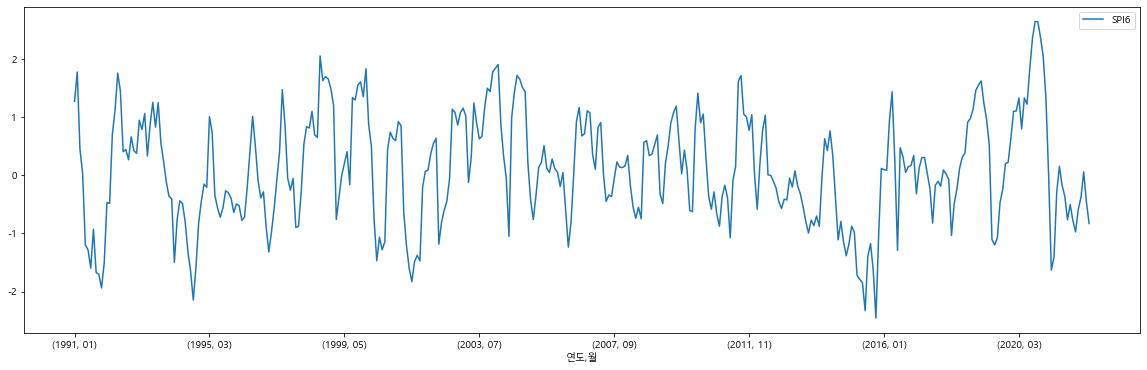

In [29]:
import seaborn as sns

spi_mean.loc[90].plot(figsize=(20, 6));

In [30]:
def label_class(spi):
    if 1 <= spi:            return 0
    elif -1 < spi < 1:      return 1
    elif -1.5 < spi <= -1:  return 2
    elif -2 < spi <= -1.5:  return 3
    elif -2 > spi:          return 4
    

spi_mean['SPI6_OX'] = spi_mean['SPI6'].map(lambda x: 0 if x > -1 else 1)
spi_mean['SPI6_5C'] = spi_mean['SPI6'].map(label_class)
spi_mean.head()

SPI6  SPI6_OX  SPI6_5C
지점 연도   월                             
90 1991 01  1.276767        0        0
        02  1.782500        0        0
        03  0.452613        0        1
        04  0.031967        0        1
        05 -1.199903        1        2

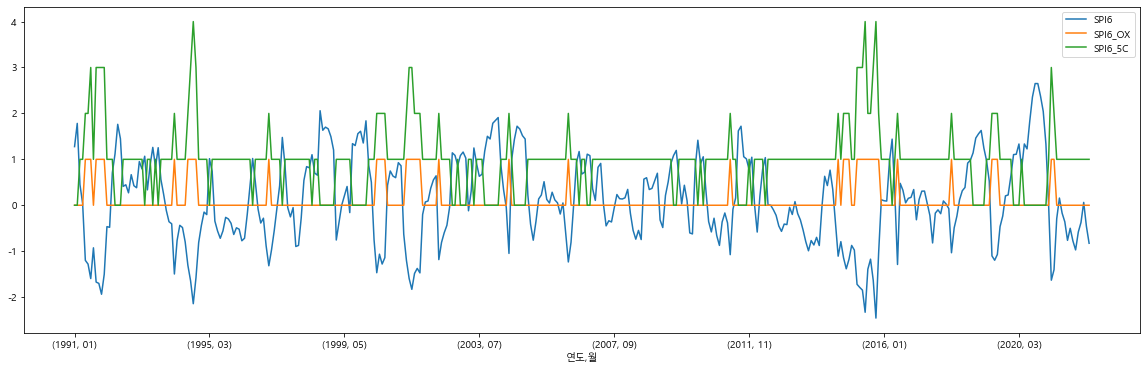

In [31]:
spi_mean.loc[90].plot.line(figsize=(20, 6));

### 데이터 살펴보기

In [32]:
train_data_raw = pd.merge(asos_mean_6m, spi_mean, on=['지점', '연도', '월']).dropna().sort_index()
train_data_raw.head(2)

평균기온      최저기온       최고기온           기압       강수량        풍속  \
지점 연도   월                                                                     
90 1991 01  12.095143  8.574409  16.091595  1016.753387  5.460573  2.996685   
        02   7.983546  4.363387  12.017325  1018.632016  5.017083  3.173643   

                 이슬점       상대습도      SPI6  SPI6_OX  SPI6_5C  
지점 연도   월                                                    
90 1991 01  6.185932  69.743889  1.276767        0        0  
        02  1.150237  64.995291  1.782500        0        0

In [33]:
train_data = train_data_raw.loc[:,:'2017',:]
train_data

평균기온       최저기온       최고기온           기압       강수량        풍속  \
지점  연도   월                                                                      
90  1991 01  12.095143   8.574409  16.091595  1016.753387  5.460573  2.996685   
         02   7.983546   4.363387  12.017325  1018.632016  5.017083  3.173643   
         03   5.446001   1.862258   9.409816  1019.291013  1.965040  3.280991   
         04   4.738026   1.067294   8.678651  1018.344597  1.681832  3.362102   
         05   5.465911   1.676810   9.428436  1016.539203  1.300721  3.318285   
...                ...        ...        ...          ...       ...       ...   
281 2017 08  19.469122  13.330161  26.231523  1000.428280  2.833011  1.829229   
         09  21.741935  15.762491  28.350287   999.542473  3.163746  1.755197   
         10  21.889265  16.350036  28.281380  1000.830842  3.034427  1.638710   
         11  19.713513  14.276559  26.112294  1002.424211  2.902724  1.608710   
         12  15.930394  10.607778  22.165269  1004.929068  2.875376  1.700269   

                   이슬점       상대습도      SPI6  SPI6_OX  SPI6_5C  
지점  연도   월                                                     
90  1991 01   6.185932  69.743889  1.276767        0        0  
         02   1.150237  64.995291  1.782500        0        0  
         03  -1.793742  62.777172  0.452613        0        1  
         04  -2.867541  61.565291  0.031967        0        1  
         05  -2.171860  61.805649 -1.199903        1        2  
...                ...        ...       ...      ...      ...  
281 2017 08  10.068244  60.516774 -1.147968        1        2  
         09  12.991362  63.086487 -1.435833        1        2  
         10  14.049857  65.888136 -1.239000        1        2  
         11  12.206183  65.984265 -1.218233        1        2  
         12   8.196111  64.021219 -0.865226        0        1  

[6480 rows x 11 columns]

In [34]:
test_data_raw = pd.merge(test_merge, spi_mean, on=['지점', '연도', '월']).dropna().sort_index()
test_data_raw.head(2)

평균기온       최저기온       최고기온           기압       강수량        풍속  \
지점 연도   월                                                                      
90 2010 07  12.233559   8.572716  16.169971  1011.838835  4.123257  2.371870   
        08  16.251604  12.744364  20.175224  1010.082222  4.069919  2.273737   

                 이슬점       상대습도      SPI6  SPI6_OX  SPI6_5C  
지점 연도   월                                                    
90 2010 07  5.309427  67.210129  0.311032        0        1  
        08  9.932115  70.126228 -0.355516        0        1

In [35]:
test_data = test_data_raw.loc[:,'2018':,:]
test_data

평균기온      최저기온       최고기온           기압       강수량        풍속  \
지점  연도   월                                                                     
90  2018 01  11.251927  7.194480  15.269355  1015.516210  3.788530  1.902464   
         02   7.407807  3.039270  11.621082  1017.400150  1.561228  2.049484   
         03   4.597023  0.207711   8.869910  1018.163839  1.633075  2.153167   
         04   4.448274 -0.122687   8.791848  1017.231631  1.348424  2.245463   
         05   6.058358  1.444252  10.639256  1015.781886  1.876758  2.213920   
...                ...       ...        ...          ...       ...       ...   
281 2022 01  11.587258  6.675726  17.662778  1007.746971  2.863817  1.531201   
         02   7.875273  2.421746  14.393959  1009.878348  1.451177  1.605658   
         03   5.340140 -0.600774  12.233719  1010.935307  0.907536  1.794688   
         04   5.179838 -1.055910  12.088504  1009.666947  0.954867  1.923704   
         05   7.110677  0.595821  13.933109  1008.687413  0.906801  1.921883   

                  이슬점       상대습도      SPI6  SPI6_OX  SPI6_5C  
지점  연도   월                                                    
90  2018 01  2.623620  59.475108 -0.071774        0        1  
         02 -2.803660  52.350947 -1.034571        1        2  
         03 -6.654799  48.178038 -0.490871        0        1  
         04 -7.250312  46.682082 -0.238333        0        1  
         05 -4.949790  50.144955  0.122484        0        1  
...               ...        ...       ...      ...      ...  
281 2022 01  6.074830  72.254821  0.212581        0        1  
         02  1.119202  66.557564  0.430741        0        1  
         03 -2.806353  60.522564 -0.732258        0        1  
         04 -3.787916  57.321051 -1.410333        1        2  
         05 -2.415045  55.847672 -2.180323        1        4  

[1265 rows x 11 columns]

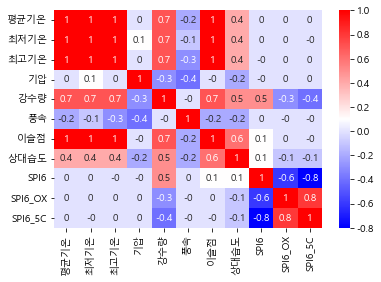

In [36]:
correlation_matrix = train_data.corr().round(1)
sns.heatmap(data=correlation_matrix, annot=True, cmap='bwr');

### 모델 검증

In [37]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)

def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re  = recall_score(y_test, pred)
    f1  = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)

    return acc, pre, re, f1, auc

In [38]:
from sklearn.metrics import confusion_matrix

def print_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, re, f1, auc = get_clf_eval(y_test, pred)

    print('==> confusion matrix')
    print(confusion)
    print('==============')

    print('Accuracy: {0:.4f}, Precision: {0:.4f}'.format(acc, pre))
    print('Recall: {0:.4f}, F1: {0:.4f}, AUC: {0:.4f}'.format(re, f1, auc))

In [39]:
from sklearn.model_selection import train_test_split
import numpy as np

X = test_data_raw.drop(['SPI6', 'SPI6_OX', 'SPI6_5C'], axis=1)
y = test_data_raw['SPI6_OX']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([2011,  441], dtype=int64))

In [40]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=13, solver='liblinear')
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

print_clf_eval(y_test, lr_pred)

==> confusion matrix
[[495  22]
 [ 60  36]]
Accuracy: 0.8662, Precision: 0.8662
Recall: 0.3750, F1: 0.3750, AUC: 0.3750


In [41]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=13, max_depth=4)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

print_clf_eval(y_test, dt_pred)

==> confusion matrix
[[497  20]
 [ 69  27]]
Accuracy: 0.8548, Precision: 0.8548
Recall: 0.2812, F1: 0.2812, AUC: 0.2812


In [42]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=100)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

print_clf_eval(y_test, rf_pred)

==> confusion matrix
[[499  18]
 [ 62  34]]
Accuracy: 0.8695, Precision: 0.8695
Recall: 0.3542, F1: 0.3542, AUC: 0.3542


In [43]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
lgbm_pred = lgbm_clf.predict(X_test)

print_clf_eval(y_test, lgbm_pred)


==> confusion matrix
[[492  25]
 [ 48  48]]
Accuracy: 0.8809, Precision: 0.8809
Recall: 0.5000, F1: 0.5000, AUC: 0.5000


In [44]:
# 모델과 데이터를 주면 성능을 출력하는 함수
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    return get_clf_eval(y_test, pred)

# 다수의 모델의 성능을 정리해서 DataFrame으로 반환하는 함수
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    tmp = []

    for model in models:
        tmp.append(get_result(model, X_train, y_train, X_test, y_test))

    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [45]:
import time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LinearReg.', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time : ', time.time() - start_time)
results

Fit time :  2.1352925300598145


,accuracy,precision,recall,f1,roc_auc
LinearReg.,0.866232,0.620690,0.375000,0.467532,0.666223
DecisionTree,0.854812,0.574468,0.281250,0.377622,0.621283
RandomForest,0.869494,0.653846,0.354167,0.459459,0.659675
LightGBM,0.880914,0.657534,0.500000,0.568047,0.725822


In [46]:
train_data_raw['기압'].values.reshape(-1, 1)

array([[1016.7533871 ],
       [1018.63201613],
       [1019.29101254],
       ...,
       [1010.73958141],
       [1010.02972478],
       [1008.88413338]])

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pressure_n = scaler.fit_transform(train_data_raw['기압'].values.reshape(-1, 1))

train_data_raw_n = train_data_raw.drop(columns=['기압'])
train_data_raw_n['기압_N'] = pressure_n
train_data_raw_n.head()

평균기온      최저기온       최고기온       강수량        풍속       이슬점  \
지점 연도   월                                                                  
90 1991 01  12.095143  8.574409  16.091595  5.460573  2.996685  6.185932   
        02   7.983546  4.363387  12.017325  5.017083  3.173643  1.150237   
        03   5.446001  1.862258   9.409816  1.965040  3.280991 -1.793742   
        04   4.738026  1.067294   8.678651  1.681832  3.362102 -2.867541   
        05   5.465911  1.676810   9.428436  1.300721  3.318285 -2.171860   

                 상대습도      SPI6  SPI6_OX  SPI6_5C      기압_N  
지점 연도   월                                                    
90 1991 01  69.743889  1.276767        0        0  0.725466  
        02  64.995291  1.782500        0        0  0.815133  
        03  62.777172  0.452613        0        1  0.846587  
        04  61.565291  0.031967        0        1  0.801414  
        05  61.805649 -1.199903        1        2  0.715243

In [48]:
X = train_data_raw_n.drop(['SPI6', 'SPI6_OX', 'SPI6_5C'], axis=1)
y = train_data_raw_n['SPI6_OX']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([5289,  906], dtype=int64))

In [49]:
start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time : ', time.time() - start_time)
results

Fit time :  4.367114067077637


,accuracy,precision,recall,f1,roc_auc
LinearReg.,0.903163,0.772414,0.489083,0.598930,0.732041
DecisionTree,0.890252,0.804124,0.340611,0.478528,0.663109
RandomForest,0.908974,0.768293,0.550218,0.641221,0.760715
LightGBM,0.916075,0.748744,0.650655,0.696262,0.806388


#### 특이 데이터 찾기

In [50]:
import plotly.graph_objects as go

fig = go.Figure()
for col_name in X_train.columns:
    fig.add_trace(go.Box(y=X_train[col_name], name=col_name))

fig.show()

In [51]:
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['SPI6_OX'] ==  1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index

    return outlier_index

In [52]:
get_outlier(df=train_data_raw_n, column='풍속', weight=1.5)

MultiIndex([(100, '2000', '05'),
            (100, '2000', '06'),
            (100, '2000', '07'),
            (100, '2011', '04')],
           names=['지점', '연도', '월'])

In [53]:
outlier_index = get_outlier(df=train_data_raw_n, column='풍속', weight=1.5)
train_data_raw_n2 = train_data_raw_n.copy()
train_data_raw_n2.shape

(7744, 11)

In [54]:
train_data_raw_n2.drop(outlier_index, axis=0, inplace=True)
train_data_raw_n2.shape

(7740, 11)

In [55]:
X = train_data_raw_n2.drop(['SPI6', 'SPI6_OX', 'SPI6_5C'], axis=1)
y = train_data_raw_n2['SPI6_OX']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([5281,  911], dtype=int64))

In [56]:
start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time : ', time.time() - start_time)
results

Fit time :  4.9044108390808105


,accuracy,precision,recall,f1,roc_auc
LinearReg.,0.916021,0.796053,0.550000,0.650538,0.763328
DecisionTree,0.896641,0.875000,0.318182,0.466667,0.655326
RandomForest,0.921189,0.826667,0.563636,0.670270,0.772029
LightGBM,0.919897,0.760870,0.636364,0.693069,0.801616


#### Oversampling

In [60]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [61]:
X_train.shape, y_train.shape

((6192, 8), (6192,))

In [62]:
X_train_over.shape, y_train_over.shape

((10562, 8), (10562,))

In [63]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([5281,  911], dtype=int64))

In [64]:
np.unique(y_train_over, return_counts=True)

(array([0, 1], dtype=int64), array([5281, 5281], dtype=int64))

In [65]:
start_time = time.time()
results = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)

print('Fit time : ', time.time() - start_time)
results

Fit time :  4.781737804412842


,accuracy,precision,recall,f1,roc_auc
LinearReg.,0.837209,0.461538,0.872727,0.603774,0.852026
DecisionTree,0.724160,0.328358,0.900000,0.481166,0.797515
RandomForest,0.890181,0.588652,0.754545,0.661355,0.833598
LightGBM,0.900517,0.624060,0.754545,0.683128,0.839622


In [ ]:
# humidity_n = scaler.fit_transform(train_data_raw['상대습도'].values.reshape(-1, 1))
# col_n2 = scaler.fit_transform(train_data_raw['이슬점'].values.reshape(-1, 1))
col_n2 = scaler.fit_transform(train_data_raw['강수량'].values.reshape(-1, 1))

train_data_raw_n2 = train_data_raw_n.drop(columns=['강수량'])
train_data_raw_n2['강수량_N'] = col_n2
train_data_raw_n2.head()

In [ ]:
X = train_data_raw_n2.drop(['SPI6', 'SPI6_OX', 'SPI6_5C'], axis=1)
y = train_data_raw_n2['SPI6_OX']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

np.unique(y_train, return_counts=True)

In [ ]:
start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print('Fit time : ', time.time() - start_time)
results

In [ ]:
import plotly.express as px

fig = px.histogram(test_data_raw, x='강수량')
fig.show()

In [ ]:
fig = px.histogram(test_data_raw, x='상대습도')
fig.show()

In [ ]:
fig = px.histogram(test_data_raw, x='평균기온')
fig.show()

In [ ]:
fig = px.histogram(test_data_raw, x='풍속')
fig.show()

In [ ]:
fig = px.histogram(test_data_raw, x='기압')
fig.show()

#### SPI6를 0과 -1로 나누었을 때

In [ ]:
X_train = train_data.drop(['SPI6', 'SPI6_OX', 'SPI6_5C'], axis=1)
X_test = test_data.drop(['SPI6', 'SPI6_OX', 'SPI6_5C'], axis=1)

y_train = train_data['SPI6_OX']
y_test = test_data['SPI6_OX']

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

drought_tree = DecisionTreeClassifier(random_state=13, max_depth=4)
drought_tree.fit(X_train, y_train)
pred = drought_tree.predict(X_test)

accuracy_score(y_test, pred)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
for col_name in X_train.columns:
    fig.add_trace(go.Box(y=X_train[col_name], name=col_name))

fig.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

MMS = MinMaxScaler()
SS = StandardScaler()

SS.fit(X_train)
MMS.fit(X_train)

X_ss = SS.transform(X_train)
X_mms = MMS.transform(X_train)

X_ss_pd = pd.DataFrame(X_ss, columns=X_train.columns)
X_mms_pd = pd.DataFrame(X_mms, columns=X_train.columns)

In [ ]:
fig = go.Figure()
for col_name in X_mms_pd.columns:
    fig.add_trace(go.Box(y=X_mms_pd[col_name], name=col_name))

fig.show()

In [ ]:
fig = go.Figure()
for col_name in X_ss_pd.columns:
    fig.add_trace(go.Box(y=X_ss_pd[col_name], name=col_name))

fig.show()

#### SPI6를 정도에 따라 0 ~ -4 까지로 나누었을 때,

In [ ]:
y_train = train_data['SPI6_5C']
y_test = test_data['SPI6_5C']

In [ ]:
drought_tree = DecisionTreeClassifier(random_state=13, max_depth=4)
drought_tree.fit(X_train, y_train)
pred = drought_tree.predict(X_test)

accuracy_score(y_test, pred)

In [ ]:
y_test, pred

In [ ]:
pred

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : range(2, 12)
}

grid_cv = GridSearchCV(drought_tree, param_grid=params, scoring='accuracy', cv=5, return_train_score=True)
grid_cv.fit(X_train, y_train)

In [ ]:
grid_cv.best_score_

In [ ]:
grid_cv.best_params_

In [ ]:
cv_result_df = pd.DataFrame(grid_cv.cv_results_)
cv_result_df[['param_max_depth', 'mean_test_score', 'mean_train_score']]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {
    'max_depth': range(2, 12),
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [8, 12],
    'min_samples_split': [8, 12]
}

drought_forest = RandomForestClassifier(random_state=13, n_jobs=-1)
grid_cv = GridSearchCV(drought_forest, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

In [ ]:
grid_cv.best_score_